<a href="https://colab.research.google.com/github/trong-khanh-1109/CS231.M13.KHCL/blob/main/Garbage_Classification_GoogleNet_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd '/content'
# !gdown https://drive.google.com/uc?id=1C8BEEW_Lw4AUj4tHYNEjKaJIA6nnqYS3 # old
# !gdown https://drive.google.com/uc?id=1cexqei_xiWRnw6ne0vyYK5g7LFlc2kbn #new
!gdown https://drive.google.com/uc?id=1t_2xCN_iLmbK1O6Fm39UTCB2xYzG2lVg

/content
Downloading...
From: https://drive.google.com/uc?id=1t_2xCN_iLmbK1O6Fm39UTCB2xYzG2lVg
To: /content/Garbage classification.zip
100% 765M/765M [00:04<00:00, 182MB/s]


In [ ]:
!unzip '/content/Garbage classification.zip'

In [ ]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


# Import library

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
FJoin = os.path.join

# Data preprocessing

In [ ]:
path = '/content/Garbage classification'

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
)

validation_datagen = ImageDataGenerator(
        rescale = 1./255
)

test_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [ ]:
img_shape = (224, 224, 3)
train_batch_size = 128
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'sparse',)

validation_generator = validation_datagen.flow_from_directory(
            path + '/validation',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'sparse',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'sparse',
            shuffle=False,)

Found 28800 images belonging to 6 classes.
Found 960 images belonging to 6 classes.
Found 961 images belonging to 6 classes.


In [ ]:
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Build model GoogleNet to extract features

In [ ]:
# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=256, activation='linear',kernel_regularizer=regularizers.l2(0.0001))(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [ ]:
CLASS_NUM = 6
IMAGE_SHAPE = (224, 224, 3)

In [ ]:
model = googlenet()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_177 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_177[0][0]']             
 )                                                                                          

In [ ]:
index = 1
for layer in model.layers:
  print("----layer " + str(index))
  print(layer)
  index = index + 1

In [ ]:
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

# Extract features using GoogleNet

## Take fully connected layers

In [ ]:
from tensorflow.keras.models import Model
layer_extract = Model(inputs=model.input, outputs=model.get_layer('dense_9').output)

In [ ]:
layer_extract.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_177 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv2d_177[0][0]']             
 )                                                                                          

## Extracting

In [ ]:
image = np.zeros((1,256))
label = np.zeros((1))
for i, (inputs_batch, labels_batch) in enumerate(train_generator):
  features_batch = layer_extract.predict(inputs_batch)
  image = np.concatenate((image, features_batch), axis = 0)
  label = np.concatenate((label,labels_batch), axis = 0)
  if (i + 1)* train_generator.batch_size >= train_generator.samples :
    print('stop')
    break
  print(i)

In [ ]:
image_train = image[1:28801,:]
label_train = label[1:28801]

In [ ]:
image = np.zeros((1,256))
label = np.zeros((1))
for i, (inputs_batch, labels_batch) in enumerate(validation_generator):
  features_batch = layer_extract.predict(inputs_batch)
  image = np.concatenate((image, features_batch), axis = 0)
  label = np.concatenate((label,labels_batch), axis = 0)
  if (i + 1)* validation_generator.batch_size >= validation_generator.samples :
    print('stop')
    break

stop


In [ ]:
image_validation = image[1:961,:]
label_validation = label[1:961]

In [ ]:
image = np.zeros((1,256))
label = np.zeros((1))
for i, (inputs_batch, labels_batch) in enumerate(test_generator):
  features_batch = layer_extract.predict(inputs_batch)
  image = np.concatenate((image, features_batch), axis = 0)
  label = np.concatenate((label,labels_batch), axis = 0)
  if (i + 1)* test_generator.batch_size >= test_generator.samples :
    print('stop')
    break

stop


In [ ]:
image_test = image[1:962,:]
label_test = label[1:962]

# Train using model SVM

## Function Plot Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load model

In [ ]:
# load the model from disk
# filename = ...
# model_SVM = pickle.load(open(filename, 'rb'))

## Kernel linear

In [ ]:
from sklearn import svm
model_SVM = svm.SVC(kernel='linear')
model_SVM.fit(image_train, label_train)

SVC(kernel='linear')

In [ ]:
y_predict_vali = model_SVM.predict(image_validation)
y_predict_test = model_SVM.predict(image_test)

----------------- Validation ------------------
              precision    recall  f1-score   support

   cardboard       0.63      0.37      0.46       160
       glass       0.43      0.33      0.37       160
       metal       0.11      0.06      0.07       160
       paper       0.23      0.22      0.22       160
     plastic       0.18      0.21      0.19       160
       trash       0.44      0.87      0.58       160

    accuracy                           0.34       960
   macro avg       0.33      0.34      0.32       960
weighted avg       0.33      0.34      0.32       960



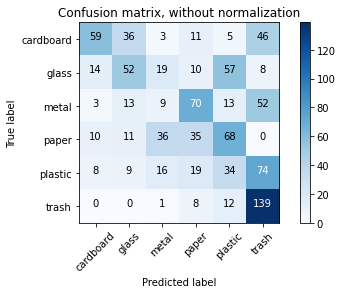

In [ ]:
print("----------------- Validation ------------------")
print(classification_report(label_validation, y_predict_vali, target_names=labels))

cnf_matrix = confusion_matrix(label_validation, y_predict_vali)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

----------------- Test ------------------
              precision    recall  f1-score   support

   cardboard       0.56      0.42      0.48       160
       glass       0.36      0.27      0.31       161
       metal       0.05      0.03      0.04       159
       paper       0.38      0.22      0.28       160
     plastic       0.15      0.24      0.18       160
       trash       0.17      0.28      0.21       161

    accuracy                           0.24       961
   macro avg       0.28      0.24      0.25       961
weighted avg       0.28      0.24      0.25       961



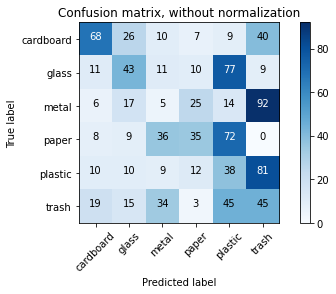

In [ ]:
print("----------------- Test ------------------")
print(classification_report(label_test, y_predict_test, target_names=labels))

cnf_matrix = confusion_matrix(label_test, y_predict_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

In [ ]:
#save model
import pickle
filename = '/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/GoogleNet_SVM/GB_GoogleNet_SVM_linear.sav'
pickle.dump(model_SVM, open(filename, 'wb'))

## Kernel rbf

In [ ]:
model_SVM = svm.SVC(kernel='rbf')
model_SVM.fit(image_train, label_train)

SVC()

In [ ]:
y_predict_vali = model_SVM.predict(image_validation)
y_predict_test = model_SVM.predict(image_test)

----------------- Validation ------------------
              precision    recall  f1-score   support

   cardboard       0.82      0.70      0.75       160
       glass       0.61      0.47      0.54       160
       metal       0.22      0.19      0.20       160
       paper       0.33      0.28      0.30       160
     plastic       0.17      0.15      0.16       160
       trash       0.50      0.89      0.64       160

    accuracy                           0.45       960
   macro avg       0.44      0.45      0.43       960
weighted avg       0.44      0.45      0.43       960



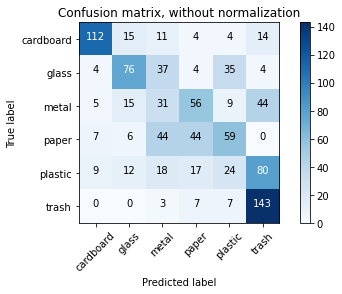

In [ ]:
print("----------------- Validation ------------------")
print(classification_report(label_validation, y_predict_vali, target_names=labels))

cnf_matrix = confusion_matrix(label_validation, y_predict_vali)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

----------------- Test ------------------
              precision    recall  f1-score   support

   cardboard       0.67      0.63      0.65       160
       glass       0.52      0.48      0.50       161
       metal       0.12      0.14      0.13       159
       paper       0.43      0.24      0.31       160
     plastic       0.19      0.19      0.19       160
       trash       0.20      0.27      0.23       161

    accuracy                           0.33       961
   macro avg       0.35      0.33      0.33       961
weighted avg       0.35      0.33      0.33       961



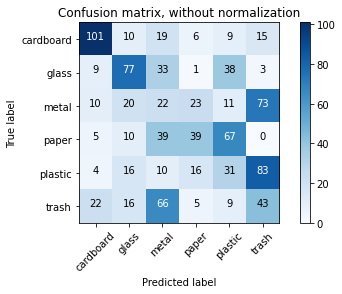

In [ ]:
print("----------------- Test ------------------")
print(classification_report(label_test, y_predict_test, target_names=labels))

cnf_matrix = confusion_matrix(label_test, y_predict_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

In [ ]:
#save model

filename = '/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/GoogleNet_SVM/GB_GoogleNet_SVM_rbf.sav'
pickle.dump(model_SVM, open(filename, 'wb'))

## Kernel polynomial

In [ ]:
model_SVM = svm.SVC(kernel='poly')
model_SVM.fit(image_train, label_train)

SVC(kernel='poly')

In [ ]:
y_predict_vali = model_SVM.predict(image_validation)
y_predict_test = model_SVM.predict(image_test)

----------------- Validation ------------------
              precision    recall  f1-score   support

   cardboard       0.76      0.72      0.74       160
       glass       0.61      0.49      0.55       160
       metal       0.31      0.28      0.29       160
       paper       0.38      0.26      0.31       160
     plastic       0.17      0.17      0.17       160
       trash       0.52      0.87      0.65       160

    accuracy                           0.47       960
   macro avg       0.46      0.47      0.45       960
weighted avg       0.46      0.47      0.45       960



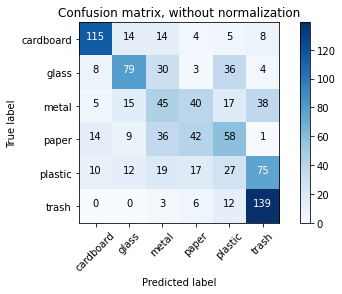

In [ ]:
print("----------------- Validation ------------------")
print(classification_report(label_validation, y_predict_vali, target_names=labels))

cnf_matrix = confusion_matrix(label_validation, y_predict_vali)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

----------------- Test ------------------
              precision    recall  f1-score   support

   cardboard       0.63      0.69      0.66       160
       glass       0.53      0.52      0.53       161
       metal       0.22      0.25      0.23       159
       paper       0.49      0.24      0.33       160
     plastic       0.21      0.23      0.22       160
       trash       0.23      0.27      0.25       161

    accuracy                           0.37       961
   macro avg       0.38      0.37      0.37       961
weighted avg       0.39      0.37      0.37       961



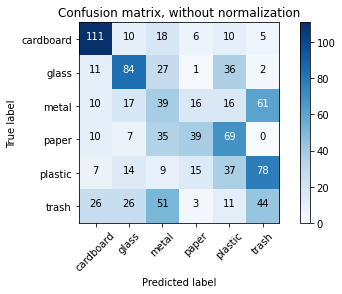

In [ ]:
print("----------------- Test ------------------")
print(classification_report(label_test, y_predict_test, target_names=labels))

cnf_matrix = confusion_matrix(label_test, y_predict_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

In [ ]:
#save model

filename = '/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/GoogleNet_SVM/GB_GoogleNet_SVM_poly.sav'
pickle.dump(model_SVM, open(filename, 'wb'))